## 3.5 图像分类数据集（Fashion-MNIST）

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
import d2lzh_pytorch as d2l

In [4]:
print(torch.__version__)
print(torchvision.__version__)

1.5.0
0.6.0


In [3]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [5]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [6]:
feature, label = mnist_train[0]
print(feature.shape, feature.dtype)  # Channel x Height X Width
print(label)

torch.Size([1, 28, 28]) torch.float32
9


In [7]:
mnist_PIL = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True)
PIL_feature, label = mnist_PIL[0]
print(PIL_feature)

<PIL.Image.Image image mode=L size=28x28 at 0x163437850D0>


In [8]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [9]:
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

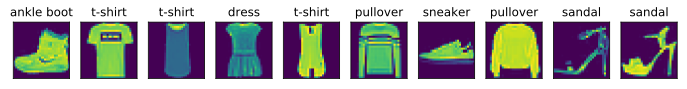

In [10]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

### 3.5.2 读取小批量

In [11]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [12]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

4.15 sec


小结
* Fashion-Mnist是一个10类服饰分类数据集
* 将高和宽分别为h和w像素的图形的形状记为h * w或（h,w）
## 3.6 Softmax回归从零开始实现

In [13]:
import torch
import torchvision
import numpy as np
import sys
import d2lzh_pytorch as d2l

### 3.6.1 获取和读取数据

In [14]:
# 使用Fashion——mnist数据集，并设置批量大小为256
batch_size = 256
brian_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.6.2 初始化模型参数
用向量表示每个样本，每个样本输入是高和宽均为28像素的图像。模型的输入向量长度为28 * 28=784：该向量每个元素对应图像中每个像素


图像有10个类别，单层神经网络输出层的输出个数为10，softmax回归的权重和偏差参数分为为784 * 10和1 * 10 的矩阵

In [15]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

# 模型参数梯度
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 3.6.3 实现softmax运算
对多维tensor按维度操作。给定一个tensor矩阵X，只对其中同一列（dim=0）或同一行（dim=1）的元素求和，并在结果中保留行和列这两个维度（keepdim=True）

In [16]:
X = torch.tensor([[1,2,3],[4,4,6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 6, 9]])
tensor([[ 6],
        [14]])


矩阵X的行数是样本数，列数是输出个数。为表达样本预测各个输出的概率，softmax运算会通过exp函数对每个元素运算，再对exp矩阵同行元素求和，最后令矩阵每行各元素之和相除。最终得到的矩阵每行元素和为1且非负


softmax运算的输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率

In [18]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

对于随机输入，将每个元素变成了非负数，且每一行和为1

In [19]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1538, 0.1805, 0.3034, 0.1831, 0.1792],
        [0.1452, 0.1340, 0.2619, 0.2511, 0.2078]]) tensor([1., 1.])


### 3.6.4 定义模型
通过view函数将每张原始图像改成长度为num_inputs的向量

In [20]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

### 3.6.5 定义损失函数
softmax回归使用交叉熵损失函数，为得到标签的预测概率，使用gather函数。

y_hat是2个样本在3个类别的预测概率，变量y是这2个样本的标签类别。通过使用gather函数，得到预测概率

In [21]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [22]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

### 3.6.6 计算分类准确率
定义准确率accuracy函数，其中y_hat.argmax(dim=1)返回矩阵y_hat每行最大元素的索引，且返回结果与变量y形状相同。相等条件判断（y_hat.argmax(dim=1) == y）是一个类型为ByteTensor的tensor，用float（）转换为值为0（相等为假）或1（相等为真）的浮点型tensor

In [23]:
def accuracy(y_hat, y):
    return(y_hat.argmax(dim=1) == y).float().mean().item()

print(accuracy(y_hat, y))

0.5


In [24]:
# 评价模型net在数据集data_iter上的准确率
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

# 随机初始化了模型net，所以这个随机模型的准确应接近类别个数10的导数（0.1）
print(evaluate_accuracy(test_iter, net))

0.0393


### 3.6.7 训练模型

In [25]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7864, train acc 0.749, test acc 0.795
epoch 2, loss 0.5719, train acc 0.812, test acc 0.812
epoch 3, loss 0.5255, train acc 0.826, test acc 0.818
epoch 4, loss 0.5019, train acc 0.830, test acc 0.825
epoch 5, loss 0.4862, train acc 0.836, test acc 0.827


### 3.6.8 预测
给定一系列图像（第三行图像输出），比较真实标签（第一行文本输出）和模型预测结果（第二行文本输出）

In [28]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [29]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).detach().numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])


小结
* 使用softmax回归做多类别分类，softmax回归步骤类似线性回归：获取并读取数据、定义模型和损失函数并使用优化算法训练模型
## 3.7 softmax回归简洁实现

1.5.0


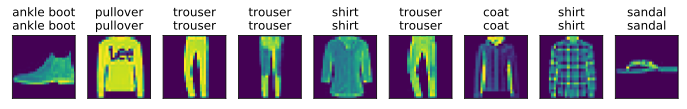

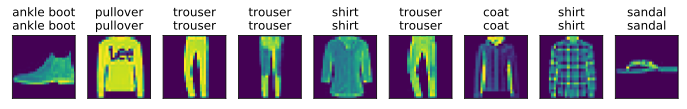

In [30]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

In [31]:
### 3.7.1 获得和读取数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.7.3 定义和初始化模型
num_inputs = 784
num_outputs = 10

# class LinearNet(nn.Module):
#     def __init__(self, num_inputs, num_outputs):
#         super(LinearNet, self).__init__()
#         self.linear = nn.Linear(num_inputs, num_outputs)
#     def forward(self, x): # x shape: (batch, 1, 28, 28)
#         y = self.linear(x.view(x.shape[0], -1))
#         return y
    
# net = LinearNet(num_inputs, num_outputs)

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

from collections import OrderedDict
net = nn.Sequential(
        # FlattenLayer(),
        # nn.Linear(num_inputs, num_outputs)
        OrderedDict([
          ('flatten', FlattenLayer()),
          ('linear', nn.Linear(num_inputs, num_outputs))])
        )

init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [32]:
### 3.7.3 softmax和交叉熵损失函数
loss = nn.CrossEntropyLoss()

### 3.7.4 定义优化算法
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

### 3.7.5 训练模型
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.748, test acc 0.776
epoch 2, loss 0.0022, train acc 0.813, test acc 0.810
epoch 3, loss 0.0021, train acc 0.826, test acc 0.818
epoch 4, loss 0.0020, train acc 0.832, test acc 0.809
epoch 5, loss 0.0019, train acc 0.835, test acc 0.823


小结
* pytorch提供函数具有更好的数值稳定性
* 使用pytorch更简洁实现softmax回归

## 3.8 多层感知机
深度学习主要关注多层模型，以多层感知机（multilay perceptron， MLP）为例，介绍多层神经网络的概念
### 3.8.1 隐藏层
多层感知机在单层神经网络的基础上引入一到多个隐藏层（hidden layer）
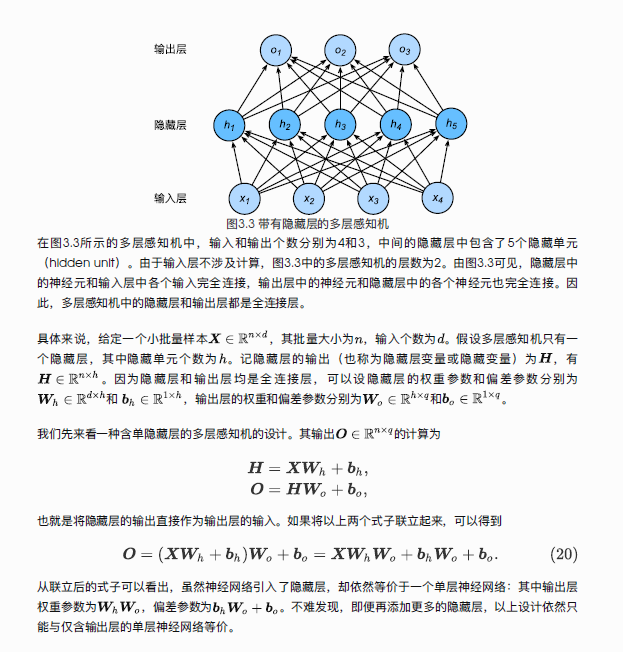

### 3.8.2 激活函数
全连接层只是对数据做仿射变换（affine transformation），而多个仿射变换的叠加仍是仿射变换。解决问题的一个方法是引入非线性变换，然后再做为下一个全连接层的输入。非线性函数称为激活函数（activation function）
#### 3.8.2.1 ReLU函数
ReLU（Rectifled linear unit）函数提供一个很简单的非线性变换
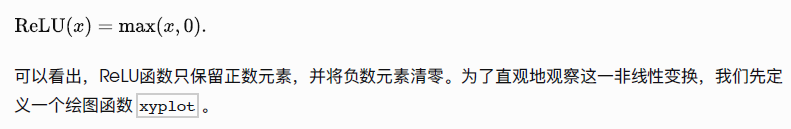

In [2]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

1.5.0


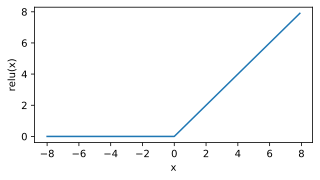

In [3]:
# 通过NDArray提供的relu函数绘制ReLU函数，激活函数是一个两段线性函数
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

当输入为负数，ReLU函数导数为0，输入为正数，ReLU函数导数为1，输入为0时ReLU函数不可导，但取导数为0，下面绘制ReLU函数导数

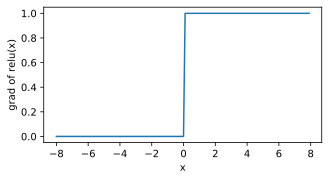

In [4]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

#### 3.8.2.2 sigmoid函数
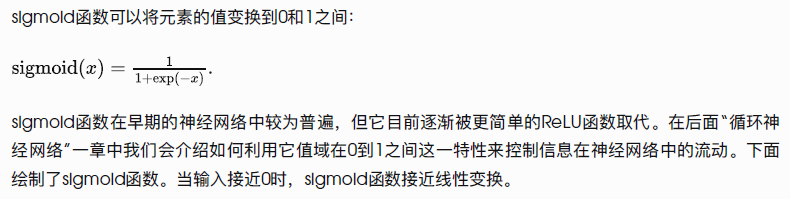

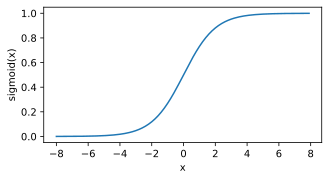

In [6]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

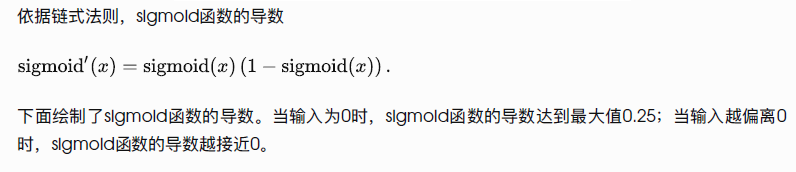

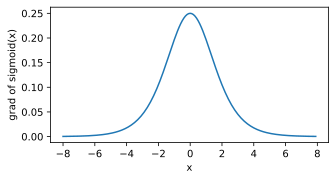

In [7]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

#### 3.8.2.3 tanh函数
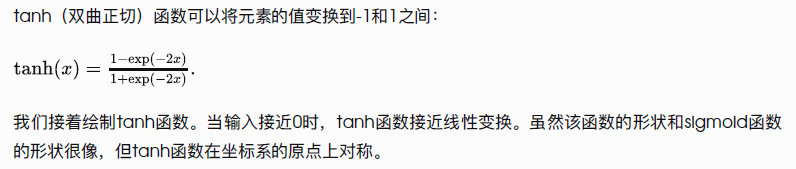

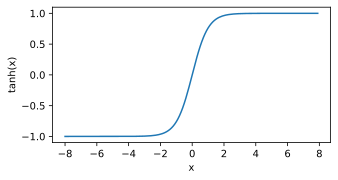

In [9]:
y = x.tanh()
xyplot(x, y, 'tanh')

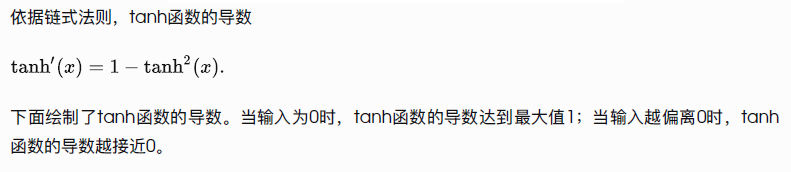

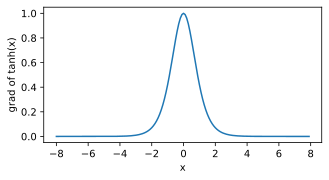

In [10]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

### 3.8.3 多层感知机
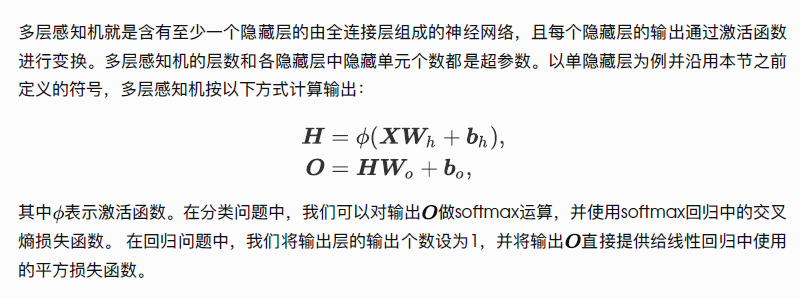
小结
* 多层感知机在输出层与输入层间加入一个或多个全连接隐藏层，并通过激活函数对隐藏层输出进行变换
* 常用的激活函数包括ReLU、sigmoid函数和tanh函数
## 3.9 多层感知机的从零开始实现

In [2]:
import torch
import numpy as np
import sys
import d2lzh_pytorch as d2l
print(torch.__version__)

### 3.9.1 获取和读取数据
# 使用Fashion——mnist数据集，用多层感知机对通向进行分类
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.9.2 定义模型参数
# Fashion——mnist图形为28*28，类别为10，用28*28=784个向量表示每一个张图
# 输入个数为784，输出为10，超参数隐藏单元个数为256
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

### 3.9.3 定义激活函数
# 使用max函数实现ReLU，而非直接调用relu函数
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

### 3.9.4 定义模型
# 同softmax回归，通过view函数将每张原始图像改成长度为num_inputs的向量
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

### 3.9.5 定义损失函数
# 直接使用Pytorch提供的包括softmax运算和交叉熵损失函数
loss = torch.nn.CrossEntropyLoss()

### 3.9.6 训练模型
# 直接调用d2l中的train_ch3函数
# 超参数迭代周期为5，学习率为100.0
num_epochs, lr = 5, 100.0
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)



1.5.0
epoch 1, loss 0.0031, train acc 0.706, test acc 0.778
epoch 2, loss 0.0019, train acc 0.824, test acc 0.818
epoch 3, loss 0.0017, train acc 0.844, test acc 0.842
epoch 4, loss 0.0015, train acc 0.855, test acc 0.826
epoch 5, loss 0.0015, train acc 0.863, test acc 0.856


小结
* 可以通过手动定义模型及其参数来实现简单的多层感知机
* 当多层感知机的层数较多时，，本节实现方法较繁琐
## 3.10 多层感知机的简洁实现
使用Gluon实现上节中的多层感知机

In [4]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import d2lzh_pytorch as d2l 
print(torch.__version__)

### 3.10.1 定义模型
# 和softmax回归唯一不同在于多加了一个全连接层作为隐藏层
# 隐藏单元个数为256，使用ReLU函数作为激活函数
num_inputs, num_outputs, num_hiddens = 784, 10, 256
    
net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs), 
        )
    
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

### 读取并训练模型
# 使用Pytorch的SGD而不是d2l里的sgd，不存在3.9节学习率很大的问题
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

1.5.0
epoch 1, loss 0.0033, train acc 0.694, test acc 0.796
epoch 2, loss 0.0019, train acc 0.816, test acc 0.727
epoch 3, loss 0.0017, train acc 0.839, test acc 0.842
epoch 4, loss 0.0015, train acc 0.854, test acc 0.847
epoch 5, loss 0.0014, train acc 0.864, test acc 0.851


小结
* 通过Pytorch更简洁实现多层感知机
## 3.11 模型选择、欠拟合和过拟合
### 3.11.1 训练误差和泛化误差
* 训练误差（training error）：训练数据集上表现出的的误差
* 泛化误差（generalization error）：模型在任意一个测试数据样本上表现出的误差
* 机器学习模型应关注降低泛化误差
### 3.11.2 模型选择
#### 3.11.2.1 验证数据集
* 测试集只能在所有超参数和模型参数选定后使用一次，不可以使用测试数据选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。
* 预留一部分在训练数据集和测试数据集以外的数据来进行模型选择，这部分数据称为验证数据集，简称验证机（validation set）
#### 3.11.2.3 K折交叉验证
由于验证集不参与模型训练，当训练数据不够用时，预留大量的验证数据太奢侈。K折交叉验证（K-flod cross-validation），将原始训练集分割成k个不重合的子数据集，然后做k次模型训练和验证。每次，使用一个子数据集验证模型，并使用其他k-1个子数据集训练模型。k次训练和验证中，每次验证模型的子数据集都不同，最后，对k次训练误差和验证误差分别求平均
### 3.11.3 欠拟合和过拟合
#### 3.11.3.1 模型复杂度
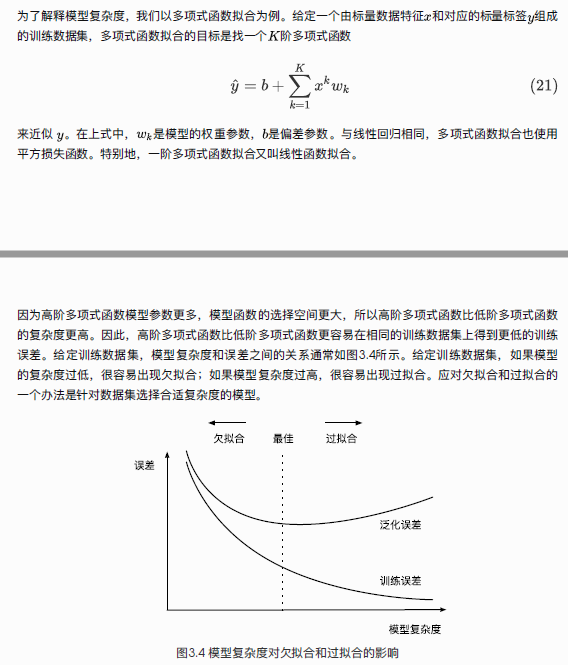

#### 3.11.3.2 训练数据集大小
* 影响欠拟合和过拟合另一个重要因素是训练集大小。训练集样本过少，特别是比模型参数数量（按元素计）更少时，更易发生过拟合。
* 泛化误差不会随训练数据集样本增大而增大
* 计算资源允许的范围内，增大训练集
### 3.11.4 多项式函数拟合实验

In [5]:
%matplotlib inline
import torch
import numpy as np
import sys
import d2lzh_pytorch as d2l 
print(torch.__version__)

1.5.0


#### 3.11.4.1 生成数据集
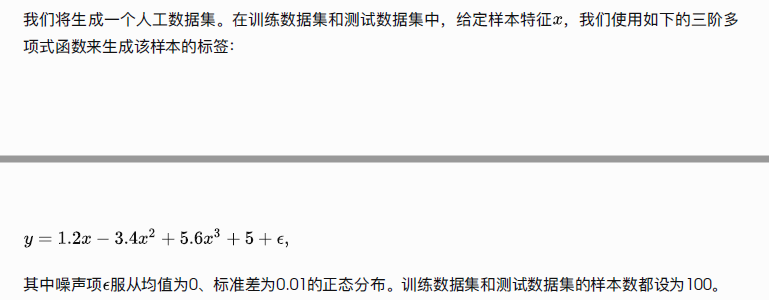

In [6]:
#### 3.11.4.1 生成数据集
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [7]:
# 看生成的数据集的前两个样本
features[:2], poly_features[:2], labels[:2]

(tensor([[-1.2756],
         [-0.1301]]),
 tensor([[-1.2756,  1.6272, -2.0757],
         [-0.1301,  0.0169, -0.0022]]),
 tensor([-13.6771,   4.7836]))

In [8]:
# 定义作图函数semilogy，其中y轴使用对数尺寸
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

和线性回归一样，多项式函数拟合也是用平方损失函数，使用不同复杂度的模型拟合生成的数据集，模型定义部分放在fit_and_plot函数中

In [9]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

#### 3.11.4.3 三阶多项式函数拟合（正常）
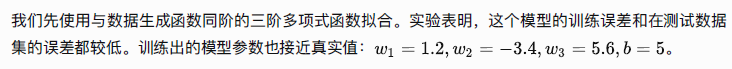

final epoch: train loss 0.00010470053530298173 test loss 9.171367855742574e-05
weight: tensor([[ 1.1993, -3.3996,  5.6005]]) 
bias: tensor([4.9980])


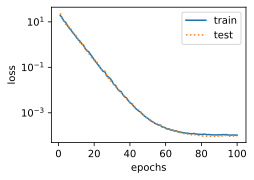

In [10]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

#### 3.11.4.4 线性函数拟合（欠拟合）
该模型的训练误差在早期下降很快后面很难继续降低。线性模型在非线性模型（如三阶多项式函数）生成的数据集上易欠拟合

final epoch: train loss 231.98260498046875 test loss 122.50951385498047
weight: tensor([[20.0976]]) 
bias: tensor([-0.5822])


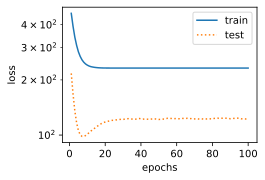

In [11]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

#### 3.11.4.5 训练样本不足（过拟合）
* 训练样本不足，模型易过拟合。
* 训练样本过少，少于模型参数的数量，使模型显得过于复杂，以至于易被训练数据中的噪声影响。
* 迭代过程中，训练误差较低，但测试数据集上误差高，典型的过拟合现象

final epoch: train loss 3.402919054031372 test loss 15.112781524658203
weight: tensor([[ 1.7872, -2.8426,  4.2906]]) 
bias: tensor([2.4890])


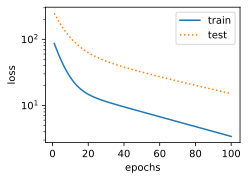

In [14]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

小结
* 无法从训练误差估计泛化误差，一味的降低训练误差不意味着泛化误差会降低。机器学习模型应关注降低泛化误差
* 使用验证数据集进行模型选择
* 欠拟合指模型无法得到较低的训练误差，过拟合指模型的训练误差远小于测试集误差
* 选择复杂度合适的模型并避免使用过少的训练样本
## 3.12 权重衰减
### 3.12.1 方法
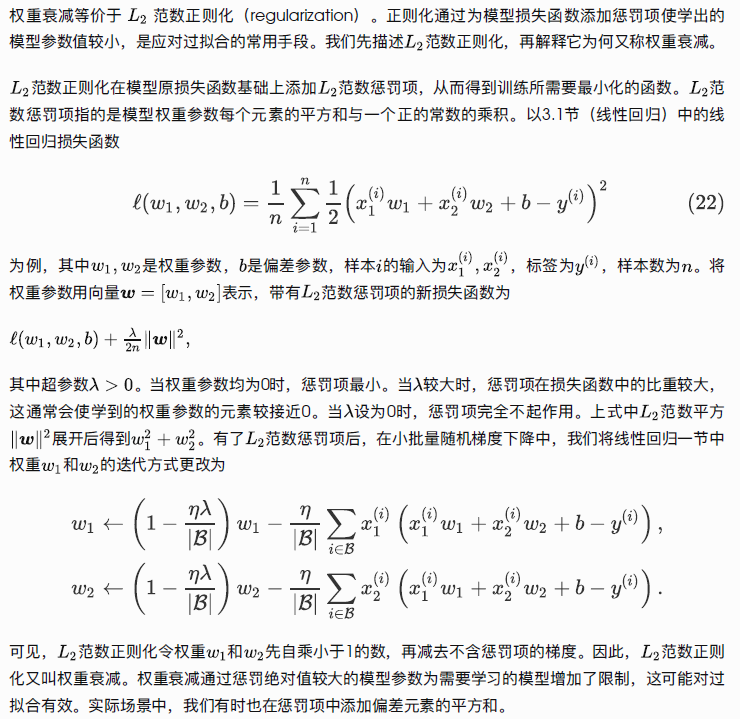

### 3.12.2 高位线性回归实验
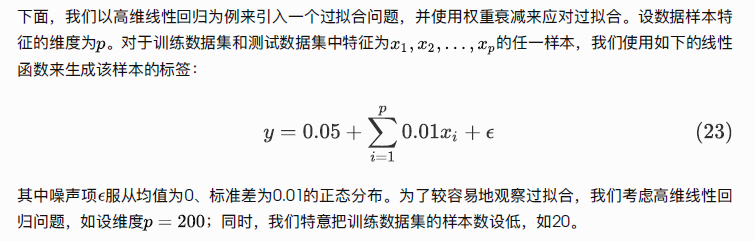

In [15]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
import d2lzh_pytorch as d2l 

n_train, m_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

### 3.12.3 从零开始实现
从零开始实现权重衰减的方法。通过在目标函数后增加L2范数惩罚项来实现权重衰减
#### 3.12.3.1 初始化模型参数
定义初始化模型参数的函数。该函数为每个参数都附上梯度

L2 norm of w: 14.35647201538086


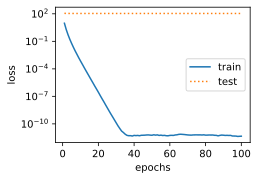

In [16]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### 3.12.3.2 定义L2范数惩罚项
# 只惩罚模型的权重参数
def l2_penalty(w):
    return (w**2).sum() / 2

#### 定义训练和测试
# 计算最终的损失函数添加L2范数惩罚项
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

#### 3.12.3.4 观察过拟合
# 训练并测试高维线性回归模型。lambd设为0时，没有使用权重衰减
# 结果训练误差远小于测试集上的误差
fit_and_plot(lambd=0)

L2 norm of w: 0.03292098641395569


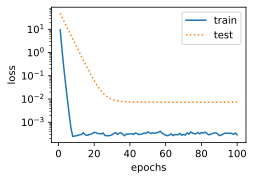

In [18]:
#### 3.12.3.5 使用权重衰减
# 训练误差有所提高，测试集误差下降，过拟合现象缓解
# 权重参数的L2范数比不使用权重衰减时的更小，权重参数更接近0
fit_and_plot(lambd=3)

### 3.12.4 简洁实现
* 直接在构造优化器实例通过weight_decay参数来指定权重衰减超参数
* 默认下，pytorch对权重和偏差同时衰减，可以对权重和偏差构造优化器实例，只对权重衰减

In [19]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 12.260689735412598


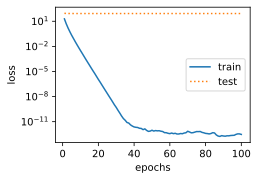

In [20]:
# 使用权重衰减在一定程度下缓解过拟合问题
fit_and_plot_pytorch(0)

L2 norm of w: 0.06266268342733383


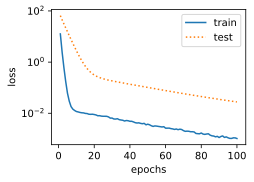

In [21]:
fit_and_plot_pytorch(3)

小结
* 正则化通过模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段
* 权重衰减等价于L2范数正则化，通常使学到的权重参数较接近0
* 权重衰减可通过优化器中weight_decay超参数来指定
* 定义多个优化器实例对不同的模型参数使用不同的迭代方法
## 3.13 丢弃法
深度学习常使用丢弃法（dropout）来应对过拟合问题
* 本节提到的丢弃法特指倒置丢弃法（inverted dropout）
### 3.13.1 方法
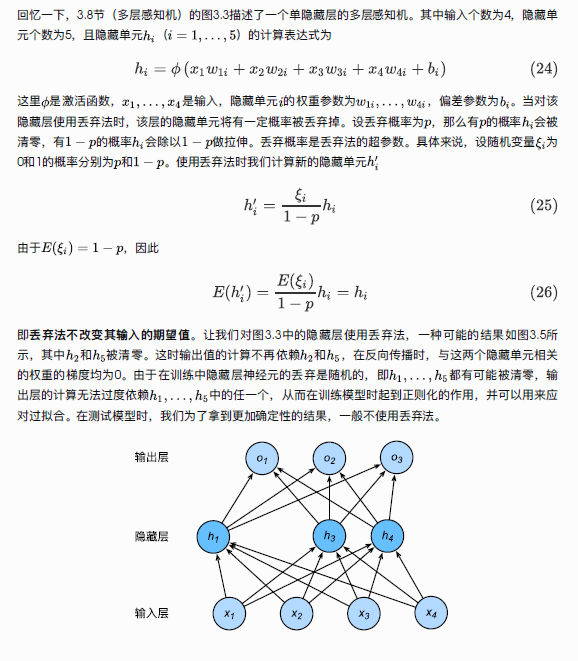
### 3.12.3 从零开始实现
dropout函数将以drop_prob的概率丢弃X中的元素

In [22]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

1.5.0


In [23]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    
    return mask * X / keep_prob

In [24]:
# 运行几个例子来测试dropout函数，丢弃概率分布为0、0.05和1
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [25]:
dropout(X, 0.5)

tensor([[ 0.,  0.,  4.,  6.,  0.,  0.,  0.,  0.],
        [16.,  0.,  0.,  0., 24., 26.,  0., 30.]])

In [26]:
dropout(X, 1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [29]:
#### 3.13.2.1 定义模型参数
# 使用Fashion——Mnist数据集
# 定义一个包含两个隐藏层的多层感知机，两个隐藏层输出个数都为256

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

In [30]:
#### 3.13.2.2 定义模型
# 将全连接层和激活函数ReLU串联，并对每个激活函数的输出使用丢弃法
# 分别设置各个层的丢弃概率，建议靠近输入层的丢弃概率设得小一点
# 第一个隐藏层丢弃概率0.2，第二个隐藏层丢弃概率0.5
# 参数is_training函数判读运行模式为训练还是测试，只需在训练模式下使用丢弃法
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3

# 对模型评估时不进行丢弃，修改d2l中得evaluate_accuracy函数
# def evaluate_accuracy(data_iter, net):
#     acc_sum, n = 0.0, 0
#     for X, y in data_iter:
#         if isinstance(net, torch.nn.Module):
#             net.eval() # 评估模式, 这会关闭dropout
#             acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
#             net.train() # 改回训练模式
#         else: # 自定义的模型
#             if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
#                 # 将is_training设置成False
#                 acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
#             else:
#                 acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
#         n += y.shape[0]
#     return acc_sum / n

#### 3.13.2.3 训练和测试模型
num_epochs, lr, batch_size = 5, 100.0, 256 # 这里的学习率设置的很大，原因同3.9.6节。
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0046, train acc 0.537, test acc 0.731
epoch 2, loss 0.0024, train acc 0.781, test acc 0.798
epoch 3, loss 0.0019, train acc 0.821, test acc 0.799
epoch 4, loss 0.0018, train acc 0.838, test acc 0.844
epoch 5, loss 0.0016, train acc 0.848, test acc 0.825


### 3.13.3 简洁实现
* Pytorch在全连接层后添加Dropout层并指定丢弃概率
* 训练模型时，Dropout层将以指定的丢弃概率随机丢弃上一层的输出元素
* 测试模式时，medel.eval()后，Dropout层不发挥作用

In [31]:
net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [32]:
# 训练并测试模型
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0045, train acc 0.556, test acc 0.738
epoch 2, loss 0.0023, train acc 0.788, test acc 0.767
epoch 3, loss 0.0019, train acc 0.825, test acc 0.827
epoch 4, loss 0.0017, train acc 0.838, test acc 0.848
epoch 5, loss 0.0016, train acc 0.848, test acc 0.846


小结
* 通过丢弃法应对过拟合
* 丢弃法只在训练模型时使用
## 3.14 正向传播、反向传播和计算图
* 提供模型正向传播的计算，即对输入计算输出，通过autograd模块调用系统自动生成的backward函数计算梯度
* 反向传播（back-propagation）算法自动求梯度极大简化深度学习模型训练算法的实现
* 以带L2范数正则化的含单隐藏层的多层感知机为样例模型解释正向传播和反向传播
### 3.14.1 正向传播
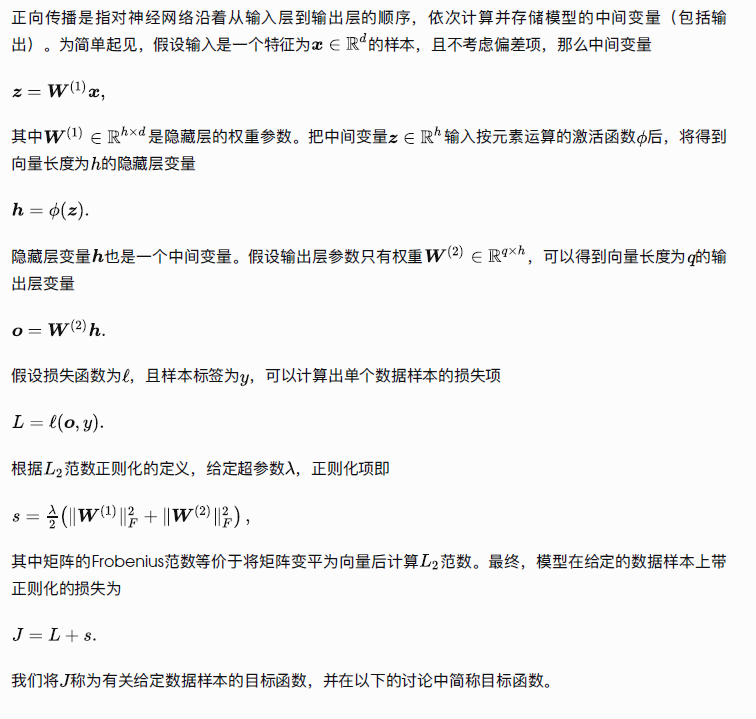

### 3.14.2 正向传播的计算图
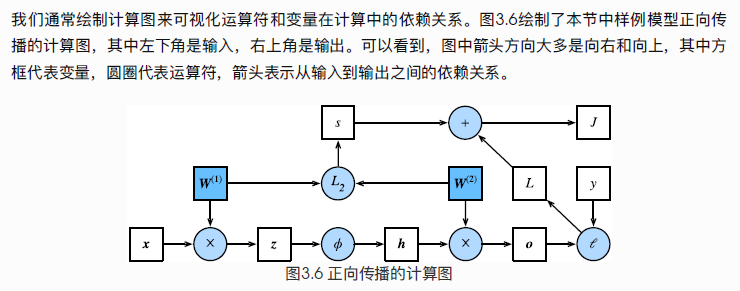

### 3.14.3 反向传播
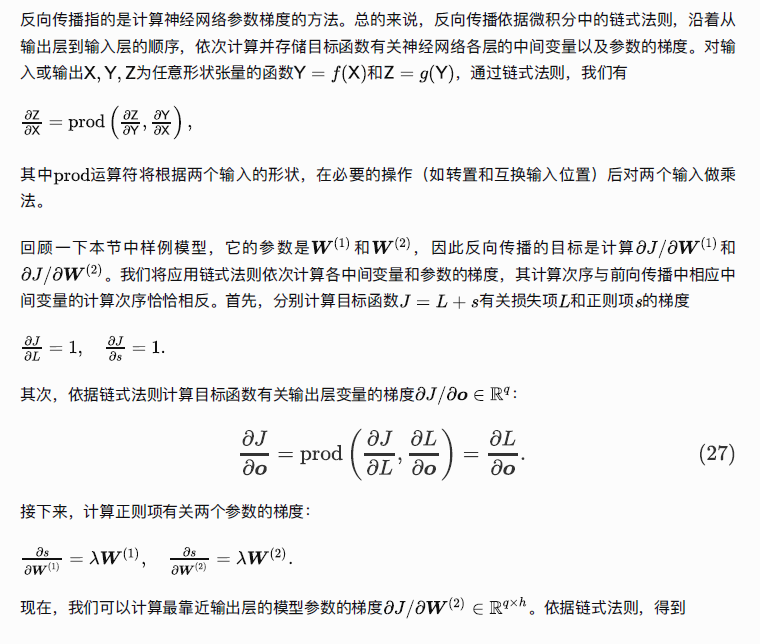

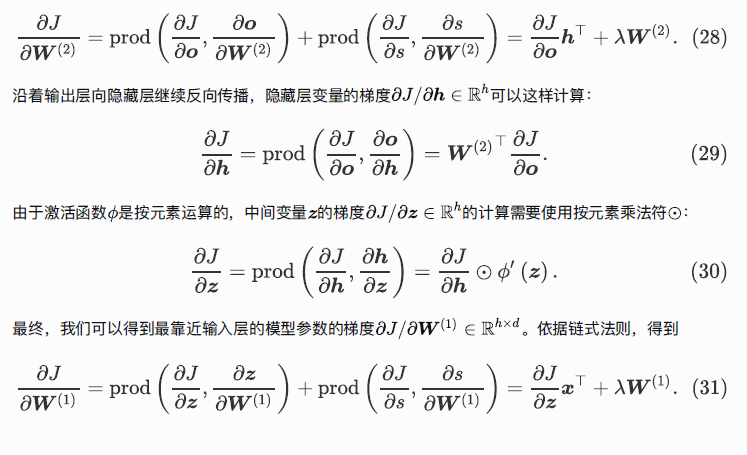

### 3.14.4 训练深度学习模型
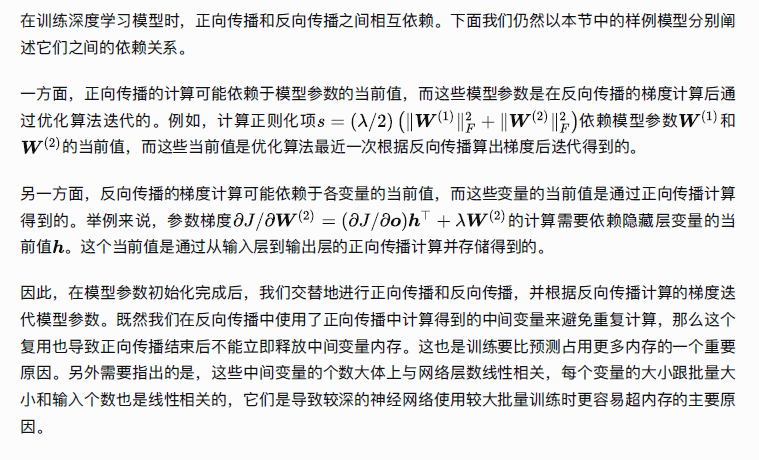
小结
* 正向传播沿着输入层到输出层的顺序，依次计算并存储神经网络的中间变量
* 反向传播沿着输出层到输入层的顺序，依次计算并存储神经网络中间变量和参数的梯度
* 训练深度学习模型时，正向传播和反向传播相互依赖
## 3.15 数值稳定性和模型初始化
* 深度模型有关数值稳定性的典型问题是衰减（vanishing）和爆炸（explosion）

### 3.15.1 衰减和爆炸
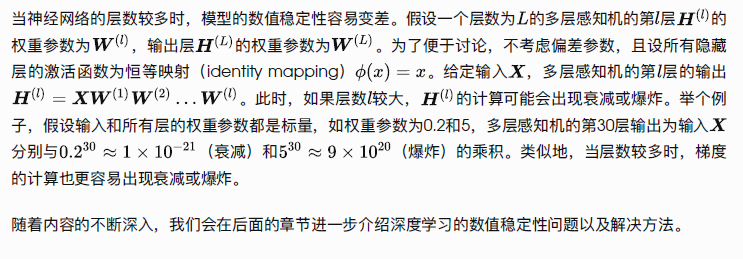

### 3.15.2 随机初始化模型参数
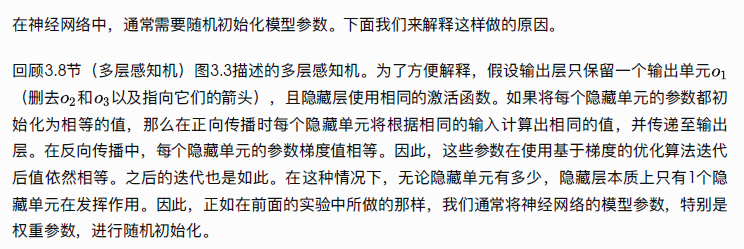

#### 3.15.2.1 Pytorch默认随机初始化
* torch.nn.init.normal_()使模型net()权重参数采用正态分布的随机初始化方式
* Pytorch中nn.Module模块参数都采取了较为合理的初始化策略
#### 3.15.2.2 Xavier随机初始化
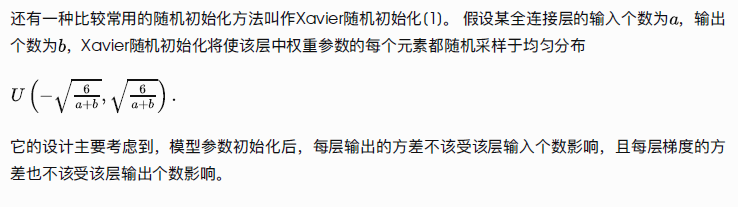
小结
* 深度模型有关数值稳定性的典型问题是衰减和爆炸。当神经网络的层数较多时，模型的数值稳定性易变差
* 需要随机初始化神经网络的模型参数，如权重参数
## 3.16 实战KAGGLE比赛：房价预测
### 3.16.1 KAGGLE比赛
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
### 3.16.2 获取和读取数据集
比赛数据分为训练数据集和测试数据集。两个数据集包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等等特征值。特征值有连续数字、离散的标签甚至缺失值“na”。只有训练数据集包括每栋房子的价格，也就是标签。
https://blog.csdn.net/Nyte2018/article/details/89977261


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import sys
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.5.0


In [2]:
# 使用pandas读取两个文件
train_data = pd.read_csv('D:\\学习\\科研\\2019年 生态中心\\Python\\pytorch\\house-prices-advanced-regression-techniques\\train.csv')
test_data = pd.read_csv('D:\\学习\\科研\\2019年 生态中心\\Python\\pytorch\\house-prices-advanced-regression-techniques\\test.csv')

In [3]:
# 训练数据集包括1460个样本、80个特征和1个标签
train_data.shape # 输出(1460, 81)

(1460, 81)

In [4]:
# 测试数据集包括1459个样本和80个特征
# 需要将测试数据集每个样本的标签预测出来
test_data.shape # 输出(1459, 80)

(1459, 80)

In [6]:
# 查看前4个样本的前4个特征、后2个特征和标签（SalePrice）
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [8]:
# 将所有训练数据和测试数据的79个特征按样本连接
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [10]:
### 3.16.3 预处理数据
# 对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为u，标准差为σ
# 将该特征值的每个值先减去u再除以σ得到标准化后的每个特征值
# 对于缺失的特征值，将其替换成该特征的均值
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [12]:
# 将离散值转化成指示特征
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # （2919， 354）

(2919, 331)

In [13]:
# 通过values属性得到Numpy格式数据，并转成NDArray方便后面的训练
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

In [14]:
### 3.16.4 训练模型
# 使用一个线性回归模型和平方损失函数来训练模型
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

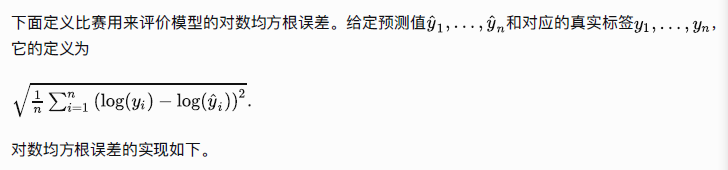

In [15]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [16]:
# 使用Adam优化算法
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [17]:
### 3.16.5 K折交叉验证
# 选择模型设计并调节超参数
# 返回第i折交叉验证时所需要的训练和验证数据
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [18]:
# K折交叉验证中训练K次并返回训练和验证的平均误差
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.170464, valid rmse 0.157708
fold 1, train rmse 0.162539, valid rmse 0.193821
fold 2, train rmse 0.163762, valid rmse 0.168232
fold 3, train rmse 0.168511, valid rmse 0.154785
fold 4, train rmse 0.162993, valid rmse 0.183112
5-fold validation: avg train rmse 0.165654, avg valid rmse 0.171532


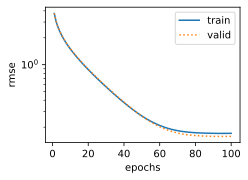

In [19]:
### 3.16.6 模型选择
# 使用一组未经调优的超参数计算交叉验证误差
# 改动超参数来尽可能减小平均测试误差
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

* 一组参数的训练误差可以很低，但在K折交叉验证上的误差可能较高，这可能时由于过拟合。
* 当训练误差降低时，观察K折交叉验证上的误差是否也降低
### 3.16.7 预测并在Kaggle提交结果
* 定义预测函数
* 预测前，使用完整的训练数据集来重新训练模型，并将预测结果存在提交所需的格式

In [20]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    # submission.to_csv('./submission.csv', index=False)

train rmse 0.162474


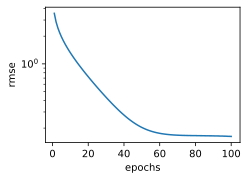

In [21]:
# 设计好模型并调好超参数后，下一步对测试数据集上的房屋样本做价格预测
# 如果得到与交叉验证差不多的训练误差，结果很可能是理想的

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)